# SETTING UP

### Import libraries

In [36]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler #to scale data 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.regularizers import l2
import warnings
import logging
from sklearn import preprocessing
import collections

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


### Set seed for reproducibility

In [37]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [38]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Importing data

In [39]:
dataset_dir = '/kaggle/input/training-datasethomework2/training_dataset_homework2'

In [40]:
X_train = np.load(os.path.join(dataset_dir,'x_train.npy'))
Y_train = np.load(os.path.join(dataset_dir,'y_train.npy'))

In [41]:
classes_dict = {0: "Wish",
          1: "Another",
          2: "Comfortably",
          3: "Money",
          4: "Breathe",
          5: "Time",
          6: "Brain",
          7: "Echoes",
          8: "Wearing",
          9: "Sorrow",
          10: "Hey", 
          11: "Shine"
          }

classes_dict.values()

dict_values(['Wish', 'Another', 'Comfortably', 'Money', 'Breathe', 'Time', 'Brain', 'Echoes', 'Wearing', 'Sorrow', 'Hey', 'Shine'])

### Splitting data

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  test_size = 0.2, 
                                                  random_state = seed,
                                                  stratify = Y_train)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print('Shapes:')
print('x_train: ', x_train.shape)
print('x_val: ', x_val.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)

Shapes:
x_train:  (1943, 36, 6)
x_val:  (486, 36, 6)
y_train:  (1943, 12)
y_val:  (486, 12)


# DATA PREPROCESSING
Insert a preprocessing routine from the notebook HW2_preprocessing.ipynb

In [43]:
#scaling along features
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

scaler = RobustScaler() #could be replaced

x_train_new = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val_new = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

print('Scaler output shape:')
x_train_new.shape, x_val_new.shape

Scaler output shape:


((1943, 36, 6), (486, 36, 6))

In [44]:
x_train = x_train_new
x_val = x_val_new

# DATA AUGMENTATION
Insert augmentation routine from HW2_augmentation&oversampling.ipynb

In [45]:
!pip install tsaug

In [46]:
#sample a random fraction of data
np.random.seed(seed)

def random_sample(X,Y, rate):
    indexes = np.random.choice(X.shape[0], size=int(np.floor(rate*X.shape[0])), replace=False)
    return X[indexes,:,:], Y[indexes,:]

x_sampled, y_sampled = random_sample(x_train, y_train, 1)

print('Sampled output shapes:')
print(x_sampled.shape)
print(y_sampled.shape)

Sampled output shapes:
(1943, 36, 6)
(1943, 12)


In [47]:
#feeding the correct shape of y to the augmenter
y_sampled_new = np.reshape(y_sampled, newshape = (y_sampled.shape[0],1,12))
y_sampled_new = np.repeat(y_sampled_new,36,axis=1)

y_sampled_new = np.argmax(y_sampled_new,axis=-1)
print('Input shapes to be fed to the augmenter:')
y_sampled_new.shape

Input shapes to be fed to the augmenter:


(1943, 36)

In [48]:
#augmenter...
from tsaug import AddNoise, Dropout, Convolve, Pool, Reverse, Drift

augmenter = (
    AddNoise(scale=0.01)
    + Dropout(p=0.05)
    + Convolve(window="flattop", size=10)
    + Pool(size = 1)
    + Reverse(prob = 0.5)
    + Drift(max_drift = 0.2, n_drift_points=3)
)

#...augment data
x_aug, y_aug = augmenter.augment(x_sampled, y_sampled_new)

In [49]:
#going back to the original shape of y to be fed to model.fit()
y_aug_new = np.reshape(np.unique(y_aug,axis=-1) , newshape = (y_aug.shape[0]))

print('Sampled output shapes (integer encoded):')
print(x_aug.shape)
print(y_aug_new.shape)

Sampled output shapes (integer encoded):
(1943, 36, 6)
(1943,)


In [50]:
#add the augmented data to the training set
x_train = np.concatenate((x_train, x_aug))
y_train = np.concatenate((y_train, tfk.utils.to_categorical(y_aug_new)))

print('Final augmented shapes:')
print(x_train.shape)
print(y_train.shape)

Final augmented shapes:
(3886, 36, 6)
(3886, 12)


# BALANCE OUR PREDICTION

Choose a method to deal with class_imbalance from HW2_augmentation&oversampling.ipynb
- no deal (often better)
- set class_weight when fitting the model
- oversampling (over_under_sampling to be implemented)

In [51]:
from sklearn.utils import class_weight
 
class_weights = class_weight.compute_class_weight(
                'balanced',
                classes = np.unique(Y_train), 
                y = Y_train)

class_weights = dict(enumerate(class_weights))  

# DROPPING FEATURES
it may be useful according to the logbook

In [52]:
x_train_new = np.delete(x_train,0,axis=2)
x_val_new = np.delete(x_val,0,axis=2)
print("Updated shapes:")
x_train_new.shape, x_val_new.shape

Updated shapes:


((3886, 36, 5), (486, 36, 5))

In [53]:
#x_train = x_train_new
#x_val = x_val_new

# BUILD, TUNE AND TRAIN 

In [54]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 500

### Tuning the model

In [55]:
import keras_tuner

In [56]:
def build_model(hp):
    
    n_feature_maps = 64

    input_layer = tfk.layers.Input(input_shape)
    
    #drop_rate of the convolutional blocks
    drop_rate_conv = 0.3
    #L2_rate of the convolutional blocks
    L2_rate = 1e-3
    
    # BLOCK 1

    conv_x = tfk.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same',
                               kernel_regularizer=tfk.regularizers.L2(L2_rate))(input_layer)
    conv_x = tfkl.Dropout(drop_rate_conv)(conv_x)    
    conv_x = tfk.layers.Activation('relu')(conv_x)

    conv_y = tfk.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same',
                               kernel_regularizer=tfk.regularizers.L2(L2_rate))(conv_x)
    conv_y = tfkl.Dropout(drop_rate_conv)(conv_y)       
    conv_y = tfk.layers.Activation('relu')(conv_y)

    conv_z = tfk.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same', 
                               kernel_regularizer=tfk.regularizers.L2(L2_rate))(conv_y)
    conv_z = tfkl.Dropout(drop_rate_conv)(conv_z)      
    
    # expand channels for the sum
    shortcut_y = tfk.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same',
                                  kernel_regularizer=tfk.regularizers.L2(L2_rate))(input_layer)
    shortcut_y = tfkl.Dropout(drop_rate_conv)(shortcut_y)

    output_block_1 = tfk.layers.add([shortcut_y, conv_z])
    output_block_1 = tfk.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = tfk.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same',
                              kernel_regularizer=tfk.regularizers.L2(L2_rate))(output_block_1)
    conv_x = tfkl.Dropout(drop_rate_conv)(conv_x) 
    conv_x = tfk.layers.Activation('relu')(conv_x)

    conv_y = tfk.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same',
                              kernel_regularizer=tfk.regularizers.L2(L2_rate))(conv_x)
    conv_y = tfkl.Dropout(drop_rate_conv)(conv_y) 
    conv_y = tfk.layers.Activation('relu')(conv_y)

    conv_z = tfk.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same',
                              kernel_regularizer=tfk.regularizers.L2(L2_rate))(conv_y)
    conv_z = tfkl.Dropout(drop_rate_conv)(conv_z) 

    # expand channels for the sum
    shortcut_y = tfk.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same',
                                  kernel_regularizer=tfk.regularizers.L2(L2_rate))(output_block_1)
    shortcut_y = tfkl.Dropout(drop_rate_conv)(shortcut_y)

    output_block_2 = tfk.layers.add([shortcut_y, conv_z])
    output_block_2 = tfk.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = tfk.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same',
                              kernel_regularizer=tfk.regularizers.L2(L2_rate))(output_block_2)
    conv_x = tfkl.Dropout(drop_rate_conv)(conv_x)
    conv_x = tfk.layers.Activation('relu')(conv_x)

    conv_y = tfk.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same',
                              kernel_regularizer=tfk.regularizers.L2(L2_rate))(conv_x)
    conv_y = tfkl.Dropout(drop_rate_conv)(conv_y)
    conv_y = tfk.layers.Activation('relu')(conv_y)
    
    conv_z = tfk.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same',
                              kernel_regularizer=tfk.regularizers.L2(L2_rate))(conv_y)
    conv_z = tfkl.Dropout(drop_rate_conv)(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = output_block_2
    shortcut_y = tfkl.Dropout(drop_rate_conv)(shortcut_y)
    
    output_block_3 = tfk.layers.add([shortcut_y, conv_z])
    output_block_3 = tfk.layers.Activation('relu')(output_block_3)

    # FINAL
    gap_layer = tfk.layers.GlobalAveragePooling1D()(output_block_3)

    dropout = tfkl.Dropout(.5, seed=seed)(gap_layer)
    
    classifier_act = 'relu' #tested also 'leaky_relu' but with worst results

    classifier = tfkl.Dense(128, activation=classifier_act, kernel_initializer = tfk.initializers.HeUniform(seed),
                           kernel_regularizer=tfk.regularizers.L2(1e-3))(dropout)

    dropout = tfkl.Dropout(.5, seed=seed)(classifier)

    classifier = tfkl.Dense(64, activation=classifier_act, kernel_initializer = tfk.initializers.HeUniform(seed),
                           kernel_regularizer=tfk.regularizers.L2(1e-3))(dropout)

    output = tfkl.Dense(
        units = classes, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(1e-2),
        name = 'output_layer')(classifier)

    model = tfk.Model(inputs=input_layer, outputs=output, name='model')

    #learning_rate = hp.Float("lr", min_value=5e-4, max_value=5e-3, sampling="log")
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

In [57]:
output_dir = '/kaggle/working/'

In [58]:
build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory= output_dir,
    project_name="conv1DResNetStyle",
)

tuner.search_space_summary()

Search space summary
Default search space size: 1
classifier_act (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}


In [59]:
tuner.search(x_train, y_train, 
             epochs=500, 
             #class_weight = class_weights,
             validation_data=(x_val, y_val),
             batch_size = batch_size
             )

Trial 2 Complete [00h 04m 23s]
val_accuracy: 0.7572016716003418

Best val_accuracy So Far: 0.7695473432540894
Total elapsed time: 00h 08m 08s


In [60]:
tuner.results_summary()

Results summary
Results in /kaggle/working/conv1DResNetStyle
Showing 10 best trials
Trial summary
Hyperparameters:
classifier_act: relu
Score: 0.7695473432540894
Trial summary
Hyperparameters:
classifier_act: leaky_relu
Score: 0.7572016716003418


### Final choice

In [61]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

In [62]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])

model.summary()
#tfk.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 36, 64)       3136        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 36, 64)       0           conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 36, 64)       0           dropout_14[0][0]                 
______________________________________________________________________________________________

In [63]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=80, restore_best_weights=True)]
).history

Epoch 1/500
31/31 [==============================] - 2s 24ms/step - loss: 8.3433 - accuracy: 0.1441 - val_loss: 3.9575 - val_accuracy: 0.3416
Epoch 2/500
31/31 [==============================] - 0s 14ms/step - loss: 4.6897 - accuracy: 0.2548 - val_loss: 3.8827 - val_accuracy: 0.3354
Epoch 3/500
31/31 [==============================] - 1s 17ms/step - loss: 4.2391 - accuracy: 0.3134 - val_loss: 3.7291 - val_accuracy: 0.3395
Epoch 4/500
31/31 [==============================] - 0s 14ms/step - loss: 3.9959 - accuracy: 0.3250 - val_loss: 3.6078 - val_accuracy: 0.3457
Epoch 5/500
31/31 [==============================] - 0s 14ms/step - loss: 3.8514 - accuracy: 0.3407 - val_loss: 3.5495 - val_accuracy: 0.3313
Epoch 6/500
31/31 [==============================] - 0s 14ms/step - loss: 3.7071 - accuracy: 0.3387 - val_loss: 3.5135 - val_accuracy: 0.3333
Epoch 7/500
31/31 [==============================] - 0s 14ms/step - loss: 3.6397 - accuracy: 0.3461 - val_loss: 3.4655 - val_accuracy: 0.3333
Epoch 

# Performance

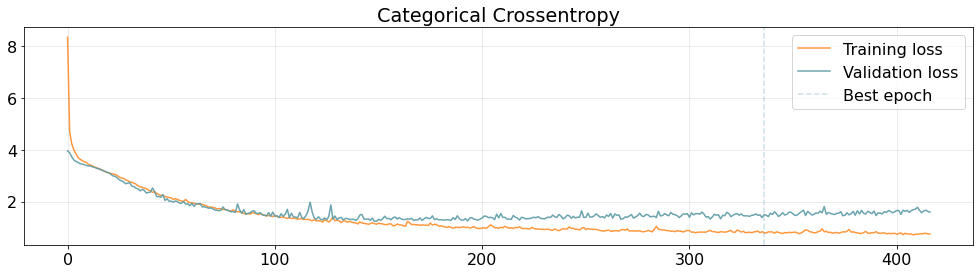

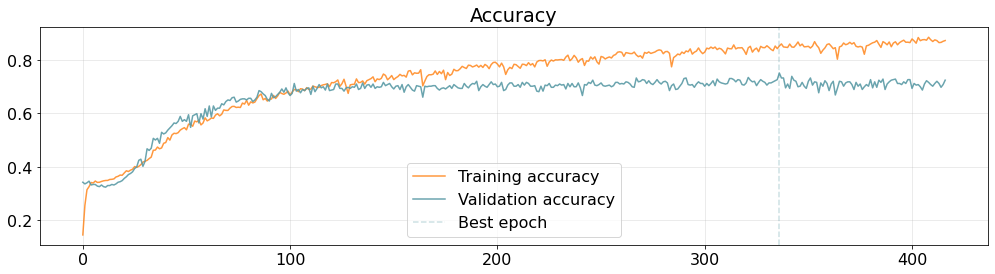

In [64]:
#plot the LOSS
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#plot the ACCURACY
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [65]:
# Predictions
predictions = model.predict(x_val)
predictions.shape

(486, 12)

In [70]:
# Predictions
predictions = best_model.predict(x_val)
predictions.shape

(486, 12)

Accuracy: 0.7695
Precision: 0.7828
Recall: 0.6391
F1: 0.6847


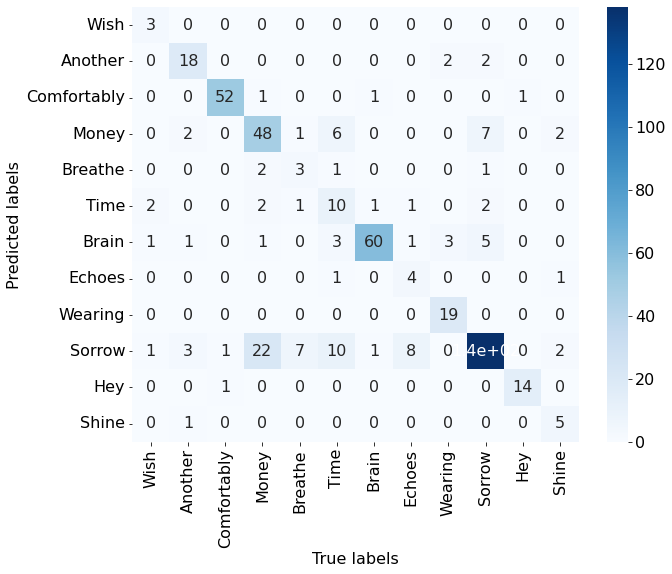

              precision    recall  f1-score   support

        Wish       1.00      0.43      0.60         7
     Another       0.82      0.72      0.77        25
 Comfortably       0.95      0.96      0.95        54
       Money       0.73      0.63      0.68        76
     Breathe       0.43      0.25      0.32        12
        Time       0.53      0.32      0.40        31
       Brain       0.80      0.95      0.87        63
      Echoes       0.67      0.29      0.40        14
     Wearing       1.00      0.79      0.88        24
      Sorrow       0.72      0.89      0.79       155
         Hey       0.93      0.93      0.93        15
       Shine       0.83      0.50      0.62        10

    accuracy                           0.77       486
   macro avg       0.78      0.64      0.68       486
weighted avg       0.77      0.77      0.76       486



In [71]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(classes_dict.values()), yticklabels=list(classes_dict.values()), annot = True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#Print the classification report
print(classification_report(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), target_names=classes_dict.values()))

In [67]:
#best_model.save('ResNet_style')